<a href="https://colab.research.google.com/github/snu-digital-finance/ProductionML/blob/main/ep70tf_TransferLearning_JH_tf_Edit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Episod70t. Transfer Learning for Task Similarity (within industry effect)

Transfer learning attempts to teach a neural network from previously trained network. Rather than training your neural network from scratch, you begin training with a preloaded set of weights. Usually, you will remove the topmost layers of the pretrained neural network and retrain it with new uppermost layers. The layers from the previous neural network will be locked so that training does not change these weights. Only the newly added layers will be trained.

## Load Tensorflow 2.0
- The following code ensures that Google CoLab is running the correct version of TensorFlow.

In [2]:
# Start CoLab
try:
    %tensorflow_version 2.x
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Note: using Google CoLab


## Step 1. Setup & Load Data

In [3]:
# import libraries
import pandas as pd
import io
import requests
import numpy as np
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

import tensorflow as tf

In [4]:
# Load Data
# I saved it on my local drive
from google.colab import files
uploaded = files.upload()

Saving CompA2019_inputdata2.csv to CompA2019_inputdata2.csv


In [5]:
# read data into pandas DataFrame
df = pd.read_csv("CompA2019_inputdata2.csv")

In [6]:
# fewer input variables
# df = df[["ff17","logq_f","lat_f","capx2a_f","che2a_f","cogs2a_f","dlc2a_f","dltt2a_f","emp2a_f","invt2a_f","ni2a_f","ppent2a_f","re2a_f","txt2a_f","xad2a_f","xint2a_f","xrd2a_f","xsga2a_f"]]
#df = df[["ff17","logq_f","lat_f","capx2a_f","dlc2a_f","dltt2a_f","emp2a_f","ppent2a_f","xad2a_f","xrd2a_f"]]
df = df[[
    "ff17",      # 산업 코드 (Fama–French 17) ─ 산업 구분용
    "logq_f",    # 로그 Tobin’s Q ─ 목표값(y)
    "lat_f",     # 총자산 로그 ─ 규모 지표
    "capx2a_f",  # 설비투자/자산
    "che2a_f",   # 현금·현금성/자산
    "cogs2a_f",  # 매출원가/자산
    "dlc2a_f",   # 단기부채/자산
    "dltt2a_f",  # 장기부채/자산
    "emp2a_f",   # 종업원수/자산
    "invt2a_f",  # 재고/자산
    "ni2a_f",    # 순이익/자산
    "ppent2a_f", # 유형자산(설비)/자산
    "re2a_f",    # 이익잉여금/자산
    "txt2a_f",   # 법인세비용/자산
    "xad2a_f",   # 광고비/자산
    "xint2a_f",  # 이자비용/자산
    "xrd2a_f",   # R&D/자산
    "xsga2a_f"   # 판매·관리비/자산
]]


In [ ]:
# task A (2 - Mines) & task B (3 - Oil)
# 15 - retail stores

#===> Change y variable of your choice below

dfA = df[df['ff17']==2]
dfB = df[df['ff17']==15]
print(dfA.shape, dfB.shape)

# drop ff17
dfA = dfA.drop(['ff17'], axis=1)
dfB = dfB.drop(['ff17'], axis=1)

# split data
RANDOM_SEED = 27 # fix train/test set
dfA_train, dfA_test = train_test_split(dfA, test_size=0.2, random_state=RANDOM_SEED)
dfB_train, dfB_test = train_test_split(dfB, test_size=0.2, random_state=RANDOM_SEED)
# dfA_train, dfA_test = train_test_split(dfA, test_size=0.2)
# dfB_train, dfB_test = train_test_split(dfB, test_size=0.2)
print(dfA_train.shape, dfA_test.shape)
print(dfB_train.shape, dfB_test.shape)

# separate input (x) and output (y)
df_xA_train = dfA_train.loc[:, dfA_train.columns != 'logq_f']
df_yA_train = dfA_train.loc[:, dfA_train.columns == 'logq_f'] # q값이 목표
df_xA_test = dfA_test.loc[:, dfA_test.columns != 'logq_f']
df_yA_test = dfA_test.loc[:, dfA_test.columns == 'logq_f']

df_xB_train = dfB_train.loc[:, dfB_train.columns != 'logq_f']
df_yB_train = dfB_train.loc[:, dfB_train.columns == 'logq_f']
df_xB_test = dfB_test.loc[:, dfB_test.columns != 'logq_f']
df_yB_test = dfB_test.loc[:, dfB_test.columns == 'logq_f']

# convert to numpy
xA_train = df_xA_train.to_numpy()
yA_train = df_yA_train.to_numpy()
xA_test = df_xA_test.to_numpy()
yA_test = df_yA_test.to_numpy()

xB_train = df_xB_train.to_numpy()
yB_train = df_yB_train.to_numpy()
xB_test = df_xB_test.to_numpy()
yB_test = df_yB_test.to_numpy()

(402, 18) (226, 18)
(321, 17) (81, 17)
(180, 17) (46, 17)


In [6]:
def dfA_model(i):
    dfA = df[df['ff17']==i]

    # drop ff17
    dfA = dfA.drop(['ff17'], axis=1)

    # split data
    RANDOM_SEED = 27 # fix train/test set
    dfA_train, dfA_test = train_test_split(dfA, test_size=0.2, random_state=RANDOM_SEED)

    # separate input (x) and output (y)
    df_xA_train = dfA_train.loc[:, dfA_train.columns != 'logq_f']
    df_yA_train = dfA_train.loc[:, dfA_train.columns == 'logq_f'] # q값이 목표
    df_xA_test = dfA_test.loc[:, dfA_test.columns != 'logq_f']
    df_yA_test = dfA_test.loc[:, dfA_test.columns == 'logq_f']

    # convert to numpy
    xA_train = df_xA_train.to_numpy()
    yA_train = df_yA_train.to_numpy()
    xA_test = df_xA_test.to_numpy()
    yA_test = df_yA_test.to_numpy()

    # Build neural network
    modelA = Sequential()
    modelA.add(Dense(20, input_dim=xA_train.shape[1], activation='relu')) # Hidden 1. 20 neurons
    modelA.add(Dense(20, activation='relu')) # Hidden 2
    modelA.add(Dense(1)) # Output

    modelA.compile(loss='mean_squared_error', optimizer='adam')

    # train Iris classification network
    modelA.fit(xA_train,yA_train,verbose=False,epochs=100) # epoch = 100

    pred = modelA.predict(xA_test)
    score = np.sqrt(metrics.mean_squared_error(pred,yA_test))

    # Save the entire model as a SavedModel.
    modelA.save(f'saved_model/model_{i}.keras')

In [7]:
!mkdir -p saved_model
for i in range(1, 18):
    dfA_model(i)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


#각 모델 간의 RMSE Heatmap

In [8]:
import os, numpy as np
from sklearn.model_selection import train_test_split

def xi_test_save(i, save_dir="saved_xi_test"):
    os.makedirs(save_dir, exist_ok=True)

    dfA = df[df["ff17"] == i].drop("ff17", axis=1)
    dfA_train, dfA_test = train_test_split(dfA, test_size=0.2, random_state=27)

    xA_test = dfA_test.drop("logq_f", axis=1).to_numpy()
    yA_test = dfA_test[["logq_f"]].to_numpy()

    np.save(os.path.join(save_dir, f"x{i}_test.npy"), xA_test)
    np.save(os.path.join(save_dir, f"y{i}_test.npy"), yA_test)

    print(f"[✔] ff17={i} test-set saved to “{save_dir}”")

In [9]:
!mkdir -p saved_xi_test
for i in range(1, 18):
    xi_test_save(i)

[✔] ff17=1 test-set saved to “saved_xi_test”
[✔] ff17=2 test-set saved to “saved_xi_test”
[✔] ff17=3 test-set saved to “saved_xi_test”
[✔] ff17=4 test-set saved to “saved_xi_test”
[✔] ff17=5 test-set saved to “saved_xi_test”
[✔] ff17=6 test-set saved to “saved_xi_test”
[✔] ff17=7 test-set saved to “saved_xi_test”
[✔] ff17=8 test-set saved to “saved_xi_test”
[✔] ff17=9 test-set saved to “saved_xi_test”
[✔] ff17=10 test-set saved to “saved_xi_test”
[✔] ff17=11 test-set saved to “saved_xi_test”
[✔] ff17=12 test-set saved to “saved_xi_test”
[✔] ff17=13 test-set saved to “saved_xi_test”
[✔] ff17=14 test-set saved to “saved_xi_test”
[✔] ff17=15 test-set saved to “saved_xi_test”
[✔] ff17=16 test-set saved to “saved_xi_test”
[✔] ff17=17 test-set saved to “saved_xi_test”


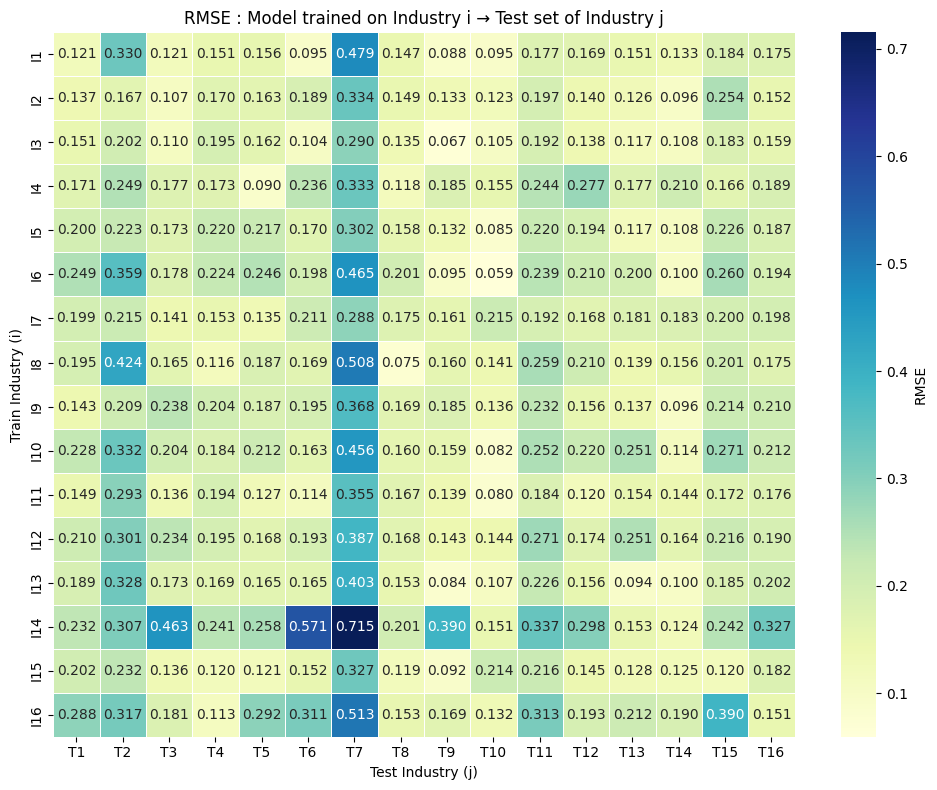

In [10]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error
import tensorflow as tf


# 1) 경로 설정
# ------------------------------------------------------------------
WEIGHT_DIR = "saved_models"      # ff17_{i}_weights.h5
TEST_DIR   = "saved_xi_test"     # x{i}_test.npy, y{i}_test.npy
# IND_LIST   = list(range(1, 18))  # 1 ~ 17
MAX_IND = 16
IND_LIST   = list(range(1, MAX_IND + 1))  # 1 ~ 16, others 제외


# 2) 데이터 로드 (산업마다 한 번씩)
# ------------------------------------------------------------------
x_tests, y_tests = {}, {}
for j in IND_LIST:
    x_tests[j] = np.load(os.path.join(TEST_DIR, f"x{j}_test.npy"))
    y_tests[j] = np.load(os.path.join(TEST_DIR, f"y{j}_test.npy"))


# 3) RMSE 매트릭스 계산
# ------------------------------------------------------------------
rmse_mat = np.zeros((MAX_IND, MAX_IND))

for i in IND_LIST:
    base_model = tf.keras.models.load_model(f'saved_model/model_{i}.keras')

    # 4-2) industry i → industry j 예측
    for j in IND_LIST:
        y_pred = base_model.predict(x_tests[j], verbose=0)
        rmse   = np.sqrt(mean_squared_error(y_tests[j], y_pred))
        rmse_mat[i-1, j-1] = rmse         # 인덱스 0-based


# 4) 히트맵 시각화
# ------------------------------------------------------------------
rmse_df = pd.DataFrame(rmse_mat, index=[f"I{i}" for i in IND_LIST],
                                     columns=[f"T{j}" for j in IND_LIST])

plt.figure(figsize=(10, 8))
sns.heatmap(rmse_df,
            annot=True, fmt=".3f",
            cmap="YlGnBu", linewidths=.5,
            cbar_kws={"label": "RMSE"})
plt.title("RMSE : Model trained on Industry i → Test set of Industry j")
plt.xlabel("Test Industry (j)")
plt.ylabel("Train Industry (i)")
plt.tight_layout()
plt.show()

# K형 산업 / L형 산업 2가지로 분류

within mean  = 0.197
cross  mean  = 0.201
Welch-t p-value (one-sided) = 0.3622


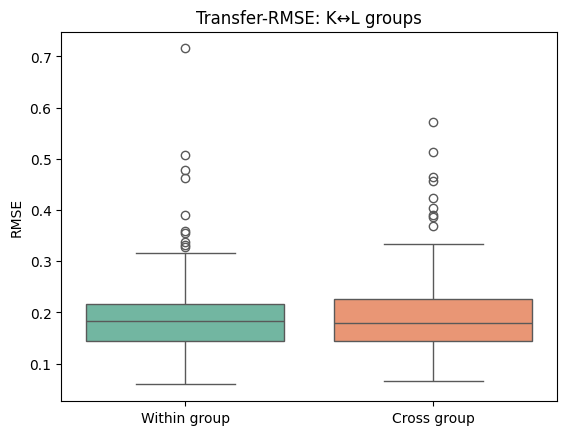

In [12]:
import numpy as np, pandas as pd
from scipy.stats import ttest_ind
import seaborn as sns, matplotlib.pyplot as plt
import tensorflow as tf

def make_KL_labels(df_full, ind_col="ff17",
                   k_var="ppent2a_f",    # PP&E / assets  → capital ratio
                   l_var="emp2a_f"):     # Employees / assets → labor ratio
    """
    Returns a dict  {industry_code: 'K' or 'L'}
    rule: industry-average capital_ratio  >  labor_ratio  → 'K', else 'L'
    """
    g = df_full.groupby(ind_col)[[k_var, l_var]].mean()
    g = g.drop(index=17, errors='ignore')
    labels = (g[k_var] > g[l_var]).map({True:"K", False:"L"}).to_dict()
    return labels, g         # also return the table for inspection


labels, _ = make_KL_labels(df)            # df = raw panel with ratios
lab_series  = pd.Series(labels)           # index = 1…17, values 'K'/'L'

# reuse rmse_df created earlier (rows = I1…17, cols = T1…17)
rmse_df.index  = lab_series.index         # 1…17
rmse_df.columns= lab_series.index

# boolean masks
row_isK = lab_series == "K"
row_isL = lab_series == "L"
col_isK = row_isK.copy()
col_isL = row_isL.copy()

within_K  = rmse_df.loc[row_isK, col_isK].values.ravel()
within_L  = rmse_df.loc[row_isL, col_isL].values.ravel()
cross_K2L = rmse_df.loc[row_isK, col_isL].values.ravel()
cross_L2K = rmse_df.loc[row_isL, col_isK].values.ravel()
cross_all = np.concatenate([cross_K2L, cross_L2K])
within_all= np.concatenate([within_K, within_L])


tstat, pval = ttest_ind(cross_all, within_all, equal_var=False)

print(f"within mean  = {within_all.mean():.3f}")
print(f"cross  mean  = {cross_all.mean():.3f}")
print(f"Welch-t p-value (one-sided) = {pval/2:.4f}")


sns.boxplot(data=[within_all, cross_all], palette=["#66c2a5", "#fc8d62"])
plt.xticks([0,1], ["Within group", "Cross group"])
plt.ylabel("RMSE")
plt.title("Transfer-RMSE: K↔L groups")
plt.show()


# K(30%), N 중립(40%), L(30%)로 분류


### Group membership
         Group
Industry      
1            K
2            L
3            K
4            K
5            K
6            N
7            N
8            L
9            N
10           N
11           K
12           N
13           L
14           L
15           L
16           N

=== Sharper K/L test (top30 vs bottom30) ===
within mean  = 0.172
cross  mean  = 0.186
one-sided Welch-t p-value = 0.1421


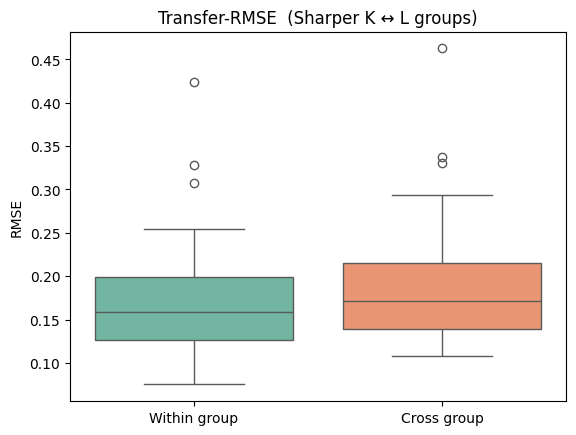

In [13]:
# ------------------------------------------------------------
# 필요한 패키지
# ------------------------------------------------------------
import os, numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# 원본 패널: df  (각 firm-year × 재무비율)
# RMSE 행렬  : rmse_df  (index & columns == 1 … 17)
# ------------------------------------------------------------

# 1. Capital- vs. Labor-intensity 지수 계산 ---------------------
#    - CapitalIndex  = PP&E/Assets  +  CAPEX/Assets
#    - LaborIndex    = Employees/Assets  +  SG&A/Assets


cap_vars = ['ppent2a_f', 'capx2a_f']
lab_vars = ['emp2a_f',  'xsga2a_f', 'xrd2a_f']

g = df.groupby('ff17')[cap_vars + lab_vars].mean()

g = g.drop(index=17, errors='ignore')

g['CapitalIdx'] = g[cap_vars].sum(axis=1)
g['LaborIdx']   = g[lab_vars].sum(axis=1)
g['Diff']       = g['CapitalIdx'] - g['LaborIdx']      # (+) = capital-heavy

# 2. 퍼센타일 컷으로 라벨링 ---------------------------
top_th, bottom_th = g['Diff'].quantile([0.70, 0.30])

def assign_label(x):
    if   x >= top_th:    return 'K'
    elif x <= bottom_th: return 'L'
    else:                return 'N'

labels = g['Diff'].apply(assign_label).to_dict()   # {ff17_code: 'K'/'L'/'N'}
lab_series = pd.Series(labels)

print("\n### Group membership")
print(pd.DataFrame({'Industry': lab_series.index,
                    'Group'   : lab_series.values})
        .set_index('Industry')
        .sort_index())

# 3.  RMSE 행렬에 라벨 적용 -----------------------------------
rmse_df.index   = lab_series.index      # 1 … 17
rmse_df.columns = lab_series.index

isK = lab_series == 'K'
isL = lab_series == 'L'

within_K  = rmse_df.loc[isK, isK].to_numpy().ravel()
within_L  = rmse_df.loc[isL, isL].to_numpy().ravel()
cross_K2L = rmse_df.loc[isK, isL].to_numpy().ravel()
cross_L2K = rmse_df.loc[isL, isK].to_numpy().ravel()

within_all = np.concatenate([within_K, within_L])
cross_all  = np.concatenate([cross_K2L, cross_L2K])

# 4. Welch-t (one-sided) --------------------------------------
tstat, p_two = ttest_ind(cross_all, within_all, equal_var=False)
p_one = p_two / 2        # H1: cross > within

print(f"\n=== Sharper K/L test (top30 vs bottom30) ===")
print(f"within mean  = {within_all.mean():.3f}")
print(f"cross  mean  = {cross_all.mean():.3f}")
print(f"one-sided Welch-t p-value = {p_one:.4f}")

# 5. 시각화 ----------------------------------------------------
sns.boxplot(data=[within_all, cross_all],
            palette=['#66c2a5', '#fc8d62'])
plt.xticks([0,1], ['Within group', 'Cross group'])
plt.ylabel('RMSE'); plt.title('Transfer-RMSE  (Sharper K ↔ L groups)')
plt.show()


/tmp/ipython-input-24-2854727237.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(data=melted[melted['Group'].isin(['K','L'])],


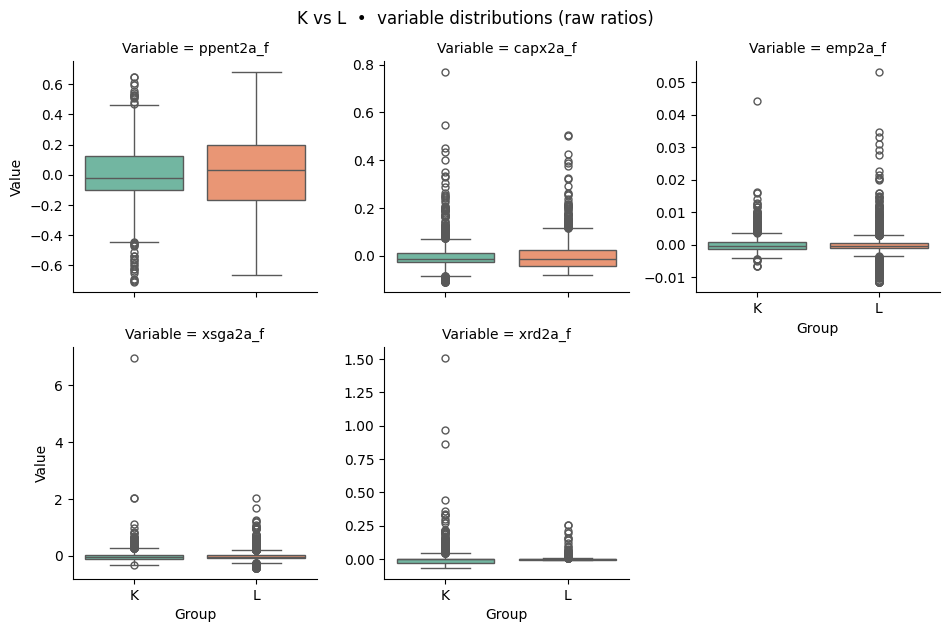

In [ ]:
# ── 스케일링하지 않은 copy
raw = df[df['ff17'] != 17].copy()
raw['Group'] = raw['ff17'].map(labels)   # K/L/N

# 긴(long) 형태로 변환 → seaborn 쉽게
melted = raw.melt(id_vars='Group',
                  value_vars=SCALE_VARS,
                  var_name='Variable', value_name='Value')

sns.catplot(data=melted[melted['Group'].isin(['K','L'])],
            x='Group', y='Value',
            col='Variable', col_wrap=3,
            kind='box', palette={'K':'#66c2a5','L':'#fc8d62'},
            sharey=False, height=3.2)
plt.subplots_adjust(top=0.9)
plt.suptitle("K vs L  •  variable distributions (raw ratios)")
plt.show()


# 변수별 정규화

/tmp/ipython-input-29-962412139.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(data=melted_s[melted_s['Group'].isin(['K','L'])],


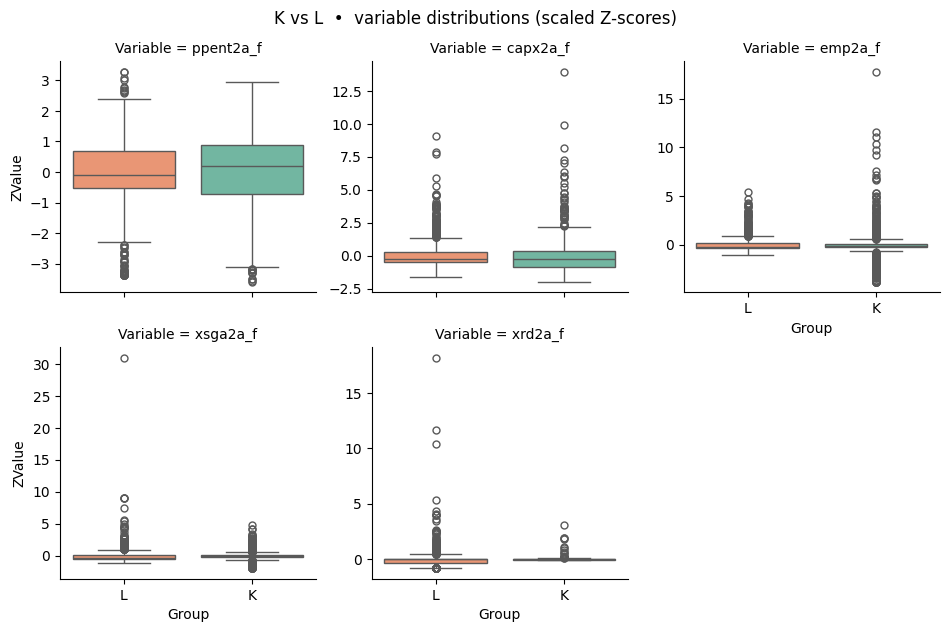

In [ ]:
# ── 스케일된 copy  (df_sub: 17 제외 + StandardScaler 적용)
scaled = df_sub.copy()
scaled['Group'] = scaled['ff17'].map(labels)   # K / L / N

# long-format 변환
melted_s = scaled.melt(id_vars='Group',
                       value_vars=SCL_VARS,        # = CAP_VARS + LAB_VARS
                       var_name='Variable', value_name='ZValue')

# 박스플롯 (또는 violin) 그리기
sns.catplot(data=melted_s[melted_s['Group'].isin(['K','L'])],
            x='Group', y='ZValue',
            col='Variable', col_wrap=3,
            kind='box',          # violin → kind='violin', inner='quartile'
            palette={'K':'#66c2a5','L':'#fc8d62'},
            sharey=False, height=3.2)

plt.subplots_adjust(top=0.9)
plt.suptitle("K vs L  •  variable distributions (scaled Z-scores)")
plt.show()


변수별 표준편차, T value 순위 - 설명력 순위

In [ ]:
# ------------------------------------------------------------
# 0) 준비
#   scaled : Z-score 처리된 firm-level 데이터프레임
#           (17 제외, 'Group' 열에 K/L/N 라벨)
#   SCL_VARS : ['ppent2a_f', 'capx2a_f', 'emp2a_f', 'xsga2a_f', 'xrd2a_f']
# ------------------------------------------------------------
k_mask = scaled['Group'] == 'K'
l_mask = scaled['Group'] == 'L'

# ------------------------------------------------------------
# 1) |mean_K − mean_L|  기준
# ------------------------------------------------------------
mean_diff = (scaled.loc[k_mask, SCL_VARS].mean() -
             scaled.loc[l_mask, SCL_VARS].mean()).abs()

rank_mean = mean_diff.sort_values(ascending=False)
print("\n[Rank ① |μK − μL|]")
print(rank_mean.to_frame('AbsMeanDiff'))

# ------------------------------------------------------------
# 2) |Welch-t|  기준
# ------------------------------------------------------------
from scipy.stats import ttest_ind

t_stats = {}
for var in SCL_VARS:
    t, _ = ttest_ind(scaled.loc[k_mask, var],
                     scaled.loc[l_mask, var],
                     equal_var=False)
    t_stats[var] = abs(t)

rank_t = pd.Series(t_stats).sort_values(ascending=False)
print("\n[Rank ② |Welch-t|]")
print(rank_t.to_frame('AbsTstat'))



[Rank ① |μK − μL|]
            AbsMeanDiff
emp2a_f    5.622068e-07
xrd2a_f    1.573481e-07
ppent2a_f  5.611045e-08
xsga2a_f   4.027662e-08
capx2a_f   9.306291e-09

[Rank ② |Welch-t|]
               AbsTstat
emp2a_f    7.504820e-06
xrd2a_f    4.957688e-06
ppent2a_f  9.989987e-07
xsga2a_f   7.451143e-07
capx2a_f   1.377462e-07


diff가 아닌 ratio 비율로 나눠보기


### Group membership (after scaling)
   Group
1      L
2      L
3      K
4      N
5      N
6      N
7      N
8      N
9      N
10     N
11     L
12     N
13     N
14     K
15     K
16     N

=== K/L test (scaled vars, 30-30 cut) ===
within mean  = 0.187
cross  mean  = 0.190
one-sided Welch-t p-value = 0.4558


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


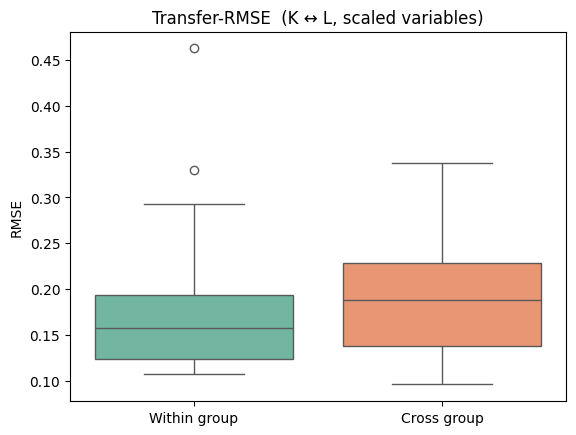

In [15]:
# ─────────────────────────────────────────────────────────────
# 0) 패키지
# ─────────────────────────────────────────────────────────────
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_ind

# ─────────────────────────────────────────────────────────────
# 1) 변수 정의 & 스케일링
# ─────────────────────────────────────────────────────────────
CAP_VARS = ['ppent2a_f', 'capx2a_f']
LAB_VARS = ['emp2a_f', 'xsga2a_f', 'xrd2a_f']
SCL_VARS = CAP_VARS + LAB_VARS

# 1-a. 기타(17) 제외한 복사본
df_sub = df[df['ff17'] != 17].copy()

# 1-b. 변수별 Z-score 변환 (전체 표본 기준)
scaler = StandardScaler()
df_sub[SCL_VARS] = scaler.fit_transform(df_sub[SCL_VARS])

# ─────────────────────────────────────────────────────────────
# 2) 산업별 Cap/Lab 지수 & K/L 라벨
# ─────────────────────────────────────────────────────────────
g = df_sub.groupby('ff17')[SCL_VARS].mean()
g['CapIdx'] = g[CAP_VARS].mean(axis=1)      # 자본지수
g['LabIdx'] = g[LAB_VARS].mean(axis=1)      # 노동지수
g['Diff']   = g['CapIdx'] - g['LabIdx']     # (+) 자본집약



# 30-30-40 컷
# top_th, bot_th = g['Diff'].quantile([.70, .30])
# labels = g['Diff'].apply(
#     lambda x: 'K' if x>=top_th else ('L' if x<=bot_th else 'N')
# ).to_dict()                                  # {1:'K',2:'L',…16:'N'}

g['Ratio'] = np.log(g['CapIdx'] / g['LabIdx'])   # 산업 평균 기준
top_th, bot_th = g['Ratio'].quantile([.70, .30])
labels = g['Ratio'].apply(lambda x: 'K' if x>=top_th else
                                     ('L' if x<=bot_th else 'N')).to_dict()

lab_ser = pd.Series(labels)
print("\n### Group membership (after scaling)")
print(lab_ser.to_frame('Group'))

# ─────────────────────────────────────────────────────────────
# 3) RMSE 매트릭스 → 17 행·열 DROP 후 K/L 검정
# ─────────────────────────────────────────────────────────────
rmse_df_sub = rmse_df.loc[lab_ser.index, lab_ser.index]
rmse_df_sub.index   = lab_ser.index
rmse_df_sub.columns = lab_ser.index

isK = lab_ser == 'K'
isL = lab_ser == 'L'

within_K  = rmse_df_sub.loc[isK, isK].values.ravel()
within_L  = rmse_df_sub.loc[isL, isL].values.ravel()
cross_K2L = rmse_df_sub.loc[isK, isL].values.ravel()
cross_L2K = rmse_df_sub.loc[isL, isK].values.ravel()

within_all = np.concatenate([within_K, within_L])
cross_all  = np.concatenate([cross_K2L, cross_L2K])

tstat, p_two = ttest_ind(cross_all, within_all, equal_var=False)
p_one = p_two/2

print(f"\n=== K/L test (scaled vars, 30-30 cut) ===")
print(f"within mean  = {within_all.mean():.3f}")
print(f"cross  mean  = {cross_all.mean():.3f}")
print(f"one-sided Welch-t p-value = {p_one:.4f}")

# ─────────────────────────────────────────────────────────────
# 4) 박스플롯
# ─────────────────────────────────────────────────────────────
sns.boxplot(data=[within_all, cross_all],
            palette=['#66c2a5','#fc8d62'])
plt.xticks([0,1],['Within group','Cross group'])
plt.ylabel('RMSE')
plt.title('Transfer-RMSE  (K ↔ L, scaled variables)')
plt.show()


# 3 - Oil 산업에 대해서 primeVar 영향 시뮬레이션

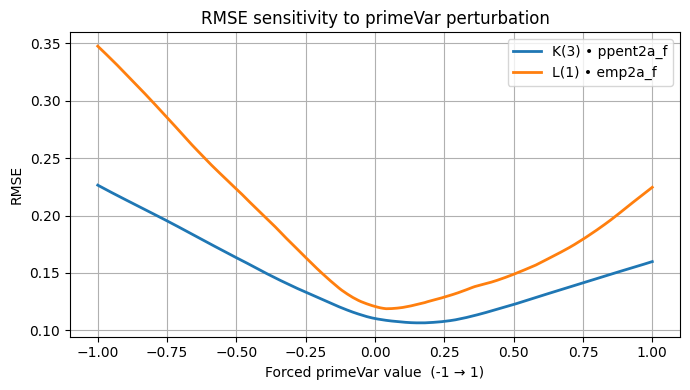

In [16]:
import os, numpy as np, matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error

# ── (1) 열 순서 매핑  ───────────────────────────────────────────
ORDER = [
    "lat_f","capx2a_f","che2a_f","cogs2a_f","dlc2a_f","dltt2a_f",
    "emp2a_f","invt2a_f","ni2a_f","ppent2a_f","re2a_f","txt2a_f",
    "xad2a_f","xint2a_f","xrd2a_f","xsga2a_f"
]
COL2IDX = {c:i for i,c in enumerate(ORDER)}

# ── (2) 대표 산업 & prime 변수  ────────────────────────────────
K_rep      = g['Ratio'].idxmax()   # Ratio = log(Cap/Lab) 예시
L_rep      = g['Ratio'].idxmin()
primeVar_K = "ppent2a_f"
primeVar_L = "emp2a_f"

# ── (3) RMSE 민감도 함수  ──────────────────────────────────────
def rmse_sensitivity(ind_code, prime_var, model_dir="saved_model"):

    # 3-a 테스트 세트 로드
    X = np.load(f"saved_xi_test/x{ind_code}_test.npy")
    y = np.load(f"saved_xi_test/y{ind_code}_test.npy")

    # 3-b 모델 로드 (.keras)
    model_path = os.path.join(model_dir, f"model_{ind_code}.keras")
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"{model_path} not found")
    model = load_model(model_path, compile=False)

    # 3-c primeVar 컬럼 index
    j = COL2IDX[prime_var]

    rmse = []
    for v in np.arange(-1, 1.01, 0.01):
        X_mod = X.copy()
        X_mod[:, j] = v
        pred  = model.predict(X_mod, verbose=0)
        rmse.append(np.sqrt(mean_squared_error(y, pred)))

    return rmse

# ── (4) 실행  ──────────────────────────────────────────────────
rmse_K = rmse_sensitivity(K_rep, primeVar_K)
rmse_L = rmse_sensitivity(L_rep, primeVar_L)

# ── (5) 플롯  ─────────────────────────────────────────────────
x_axis = np.arange(-1, 1.01, 0.01)
plt.figure(figsize=(7,4))
plt.plot(x_axis, rmse_K, label=f"K({K_rep}) • {primeVar_K}", lw=2)
plt.plot(x_axis, rmse_L, label=f"L({L_rep}) • {primeVar_L}", lw=2)
plt.xlabel("Forced primeVar value  (-1 → 1)")
plt.ylabel("RMSE")
plt.title("RMSE sensitivity to primeVar perturbation")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()


L-group industries: [2, 8, 13, 14, 15]


ValueError: x and y must have same first dimension, but have shapes (101,) and (201,)

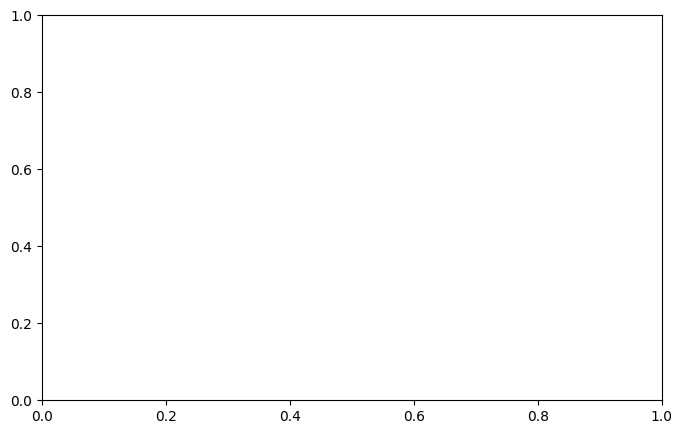

In [17]:
# =============================================================
# 0) 전제:  lab_ser (산업 → 'K'/'L'/'N'),  SCL_VARS, COL2IDX,
#           rmse_sensitivity()  함수가 앞에서 정의돼 있다고 가정
# primeVar_L = 'emp2a_f'
# =============================================================

primeVar_L = 'emp2a_f'
# L_codes = lab_ser[lab_ser == 'L'].index.tolist()
L_codes = [2, 8, 13, 14, 15]
print(f"L-group industries: {L_codes}")

rmse_dict = {}                      # {ind_code : rmse_list}

for ind in L_codes:
    rmse_dict[ind] = rmse_sensitivity(ind, primeVar_L)

# =============================================================
# 1) 플롯 — L 모든 산업 한 그래프에 (선택)
# =============================================================
import matplotlib.pyplot as plt
x_axis = np.arange(0, 1.01, 0.01)

plt.figure(figsize=(8,5))
for ind, rmse in rmse_dict.items():
    plt.plot(x_axis, rmse, label=f"L({ind})", lw=1.8)

plt.xlabel("Forced emp2a_f value  (0 → 1)")
plt.ylabel("RMSE")
plt.title("RMSE sensitivity  •  L-group industries  •  primeVar = emp2a_f")
plt.grid(True); plt.legend(title="Industry"); plt.tight_layout(); plt.show()

# =============================================================
# 2) 요약 테이블 (옵션) — 민감도 기울기 & 최대 RMSE
# =============================================================
summary = []
for ind, curve in rmse_dict.items():
    slope = curve[-1] - curve[0]           # ΔRMSE (0 → 1)
    summary.append((ind, curve[0], curve[-1], slope))

summary_df = (pd.DataFrame(summary, columns=['Ind','RMSE@0','RMSE@1','ΔRMSE'])
                .set_index('Ind')
                .sort_values('ΔRMSE', ascending=False))
print("\n[L-group primeVar 민감도 요약]")
print(summary_df)


(15분 이상 걸리는 코드)

① 데이터 준비:	ALL_VARS (15개 재무비율)·TARGET='logq_f' 을 뽑음 → df에서 산업별로 분할.

② prime 변수 선정:	산업별로 단변량 OLS → 각 변수의 R² 분산 계산 → 자본축은 re2a_f, 노동축은 txt2a_f 가 가장 들쑥날쑥 → 시뮬레이션용 “레버”로 메모.

③ 모델 빌더:	build_nnet(n_layers, n_feat)
Input → Dense(20) → Dense(20) → Dense(1)

④	각 산업마다

    ① 훈련/검증 8:2 split
    
    ② OLS (R² 추출)

    ③ 1-층 MLP 100 epoch 학습 → R²

    ④ 2-층 MLP 100 epoch 학습 → R²

    ⑤ 표 & 히트맵	결과를 DataFrame으로 정리 → sns.heatmap으로 시각화.


► Capital-prime  : re2a_f
► Labor-prime    : txt2a_f

=== R² by Industry ===


,OLS,NN_1,NN_2
Industry,,,
1,-1.574,-0.358,0.534
2,0.425,0.175,0.419
3,0.011,-0.181,0.076
4,0.081,0.237,0.118
5,0.019,-0.537,-0.150
6,-1.168,0.008,-0.779
7,-0.118,-0.181,-0.207
8,0.007,0.282,0.571
9,-1.366,-3.397,-1.068


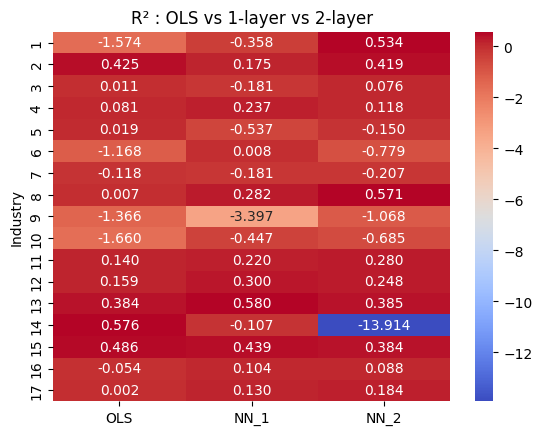

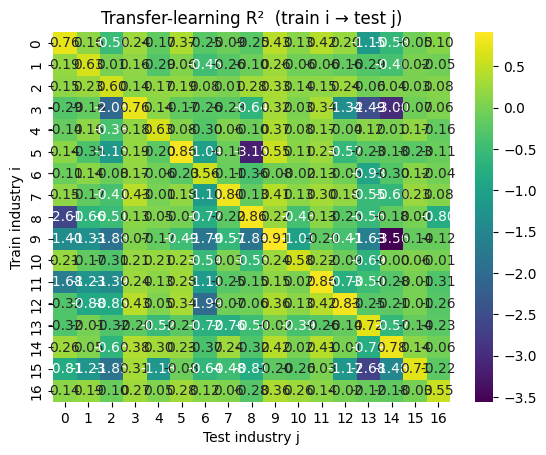

from matplotlib import pyplot as plt
r2_df['OLS'].plot(kind='hist', bins=20, title='OLS')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
r2_df['NN_1'].plot(kind='hist', bins=20, title='NN_1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
r2_df['NN_2'].plot(kind='hist', bins=20, title='NN_2')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
r2_df.plot(kind='scatter', x='OLS', y='NN_1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
r2_df.plot(kind='scatter', x='NN_1', y='NN_2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
r2_df['OLS'].plot(kind='line', figsize=(8, 4), title='OLS')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
r2_df['NN_1'].plot(kind='line', figsize=(8, 4), title='NN_1')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
r2_df['NN_2'].plot(kind='line', figsize=(8, 4), title='NN_2')
plt.gca().spines[['top', 'right']].set_visible(False)

In [10]:
# ================================================================
# A. 단변량 OLS로 ‘prime’ 변수 선정
# ================================================================
import pandas as pd, numpy as np, statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import tensorflow as tf, seaborn as sns, matplotlib.pyplot as plt
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense

# ── 0) 변수 세트 ──────────────────────────────────────────────
CAP_VARS = ["ppent2a_f","capx2a_f","dltt2a_f","dlc2a_f",
            "che2a_f","invt2a_f","re2a_f","xint2a_f"]
LAB_VARS = ["emp2a_f","xsga2a_f","xad2a_f","cogs2a_f",
            "xrd2a_f","ni2a_f","txt2a_f"]
ALL_VARS = CAP_VARS + LAB_VARS
TARGET   = "logq_f"

# ── 1) 산업별 단변량 R² ───────────────────────────────────────
r2_mat = pd.DataFrame(index=ALL_VARS, columns=range(1,18))
for ind in range(1,18):
    sub, y = df[df.ff17==ind], df.loc[df.ff17==ind, TARGET]
    for v in ALL_VARS:
        X = sm.add_constant(sub[[v]], has_constant="add")
        r2_mat.loc[v, ind] = sm.OLS(y, X).fit().rsquared

# ── 2) prime 변수 출력 ──────────────────────────────────────
var_var = r2_mat.astype(float).var(axis=1)
prime_cap = var_var.loc[CAP_VARS].idxmax()
prime_lab = var_var.loc[LAB_VARS].idxmax()
print(f"► Capital-prime  : {prime_cap}")
print(f"► Labor-prime    : {prime_lab}")

# ================================================================
# B. OLS vs 1-층 vs 2-층 MLP  (산업별 R² 비교)
# ================================================================
def build_nnet(n_layers: int, n_feat: int) -> Sequential:
    tf.keras.backend.clear_session()                 # retracing 방지
    layers = [Input(shape=(n_feat,)), Dense(20, activation="relu")]
    if n_layers == 2:
        layers.append(Dense(20, activation="relu"))
    layers.append(Dense(1))
    m = Sequential(layers)
    m.compile(optimizer="adam", loss="mse")
    return m

results = []
for ind in range(1,18):
    sub = df[df.ff17==ind]
    X, y = sub[ALL_VARS].to_numpy(), sub[[TARGET]].to_numpy()
    X_tr, X_te, y_tr, y_te = train_test_split(X,y,test_size=0.2,random_state=27)

    # OLS
    beta = sm.OLS(y_tr, sm.add_constant(X_tr,has_constant="add")).fit()
    y_hat = beta.predict(sm.add_constant(X_te,has_constant="add"))
    r2_lin = r2_score(y_te, y_hat)

    # 1-layer
    nn1 = build_nnet(1, X.shape[1]); nn1.fit(X_tr,y_tr,epochs=100,verbose=0)
    r2_nn1 = r2_score(y_te, nn1.predict(X_te,verbose=0))

    # 2-layer
    nn2 = build_nnet(2, X.shape[1]); nn2.fit(X_tr,y_tr,epochs=100,verbose=0)
    r2_nn2 = r2_score(y_te, nn2.predict(X_te,verbose=0))

    results.append({"Industry":ind,"OLS":r2_lin,"NN_1":r2_nn1,"NN_2":r2_nn2})

r2_df = pd.DataFrame(results).set_index("Industry").round(3)
print("\n=== R² by Industry ==="); display(r2_df)

sns.heatmap(r2_df, annot=True, cmap="coolwarm", fmt=".3f")
plt.title("R² : OLS vs 1-layer vs 2-layer"); plt.show()

# # ================================================================
# # C. 2-층 모델 → transfer-learning R² 행렬
# # ================================================================
# def build_base(n_feat:int) -> Sequential:
#     return build_nnet(2, n_feat)          # 동일 구조 재사용

# models = {}
# for ind in range(1,18):
#     sub = df[df.ff17==ind]
#     X, y = sub[ALL_VARS].to_numpy(), sub[[TARGET]].to_numpy()
#     m = build_base(X.shape[1]); m.fit(X,y,epochs=100,verbose=0)
#     models[ind] = m

# r2_trans = np.zeros((17,17))
# for i in range(1,18):
#     base = models[i]
#     for j in range(1,18):
#         subT = df[df.ff17==j]
#         XT, yT = subT[ALL_VARS].to_numpy(), subT[[TARGET]].to_numpy()

#         clone = tf.keras.models.clone_model(base)
#         clone.set_weights(base.get_weights())
#         for lyr in clone.layers[:-1]:
#             lyr.trainable = False
#         clone.compile(optimizer="adam", loss="mse")
#         clone.fit(XT,yT,epochs=5,verbose=0)

#         r2_trans[i-1,j-1] = r2_score(yT, clone.predict(XT,verbose=0))

# sns.heatmap(r2_trans, annot=True, fmt=".2f", cmap="viridis")
# plt.title("Transfer-learning R²  (train i → test j)")
# plt.xlabel("Test industry j"); plt.ylabel("Train industry i")
# plt.show()


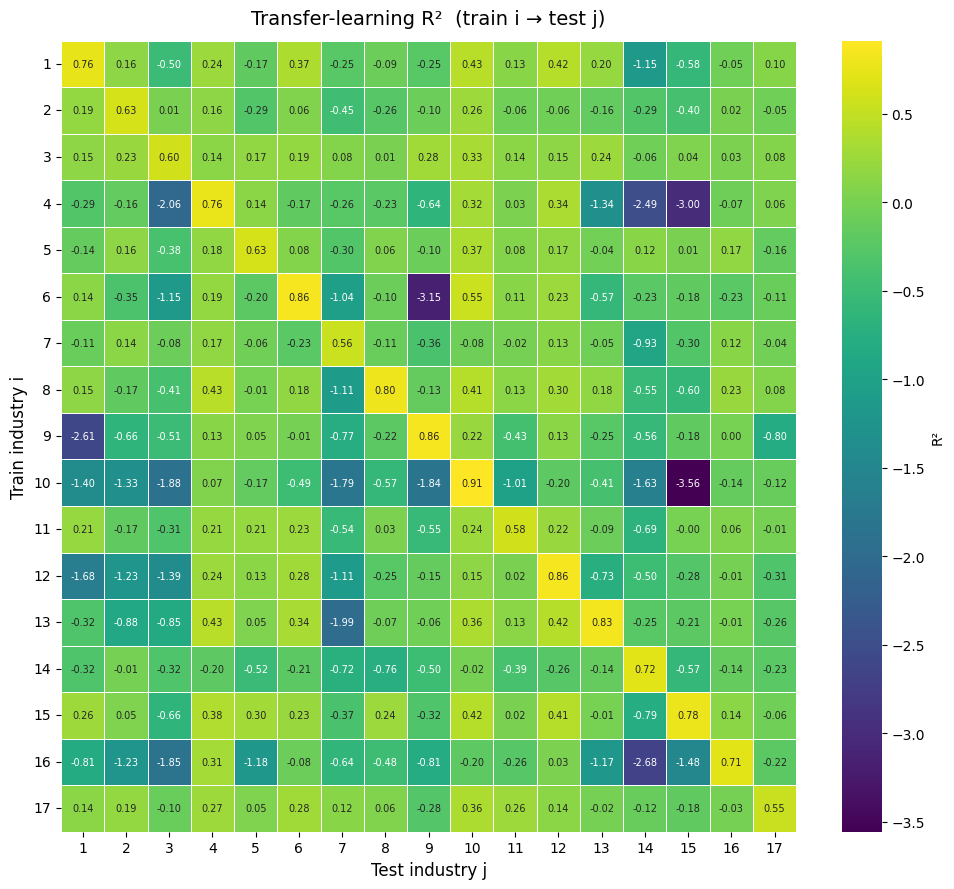

In [11]:
plt.figure(figsize=(10, 9))                            # ⬅︎ 캔버스 키우기
ax = sns.heatmap(
        r2_trans,
        annot=True,
        fmt=".2f",
        cmap="viridis",
        linewidths=.5,
        cbar_kws={"label": "R²"},
        annot_kws={"size": 7},                         # ⬅︎ 숫자 글꼴 작게
)

ax.set_title("Transfer-learning R²  (train i → test j)", fontsize=14, pad=12)
ax.set_xlabel("Test industry j", fontsize=12)
ax.set_ylabel("Train industry i", fontsize=12)

# 눈금 라벨을 1~17로 명시
ax.set_xticklabels(range(1, 18), rotation=0)
ax.set_yticklabels(range(1, 18), rotation=0)

plt.tight_layout()
plt.show()

,ff17,n_samples
0,1,139
1,2,402
2,3,322
3,4,51
4,5,82
5,6,95
6,7,247
7,8,162
8,9,50
9,10,30


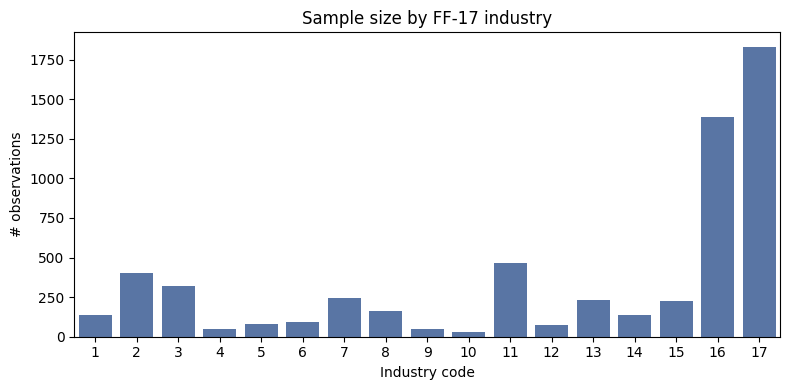

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) 산업별 샘플 수 집계
sample_counts = (
    df.groupby("ff17")          # 산업 코드로 그룹화
      .size()                   # 행 개수 세기
      .reset_index(name="n_samples")
      .sort_values("ff17")      # 1 → 17 순으로 정렬
)

# 2) 표로 확인
display(sample_counts)

plt.figure(figsize=(8,4))
sns.barplot(data=sample_counts, x="ff17", y="n_samples", color="#4C72B0")
plt.title("Sample size by FF-17 industry")
plt.xlabel("Industry code"); plt.ylabel("# observations")
plt.tight_layout(); plt.show()


# Transfer Learning Heatmap

진행바 추가 (10분 이상 걸림)

In [ ]:
from tqdm.notebook import tqdm
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense

# ------------------------------------------------------------
# 1) Full Learning  -----------------------------
# ------------------------------------------------------------
def build_nnet(n_layers:int, n_feat:int):
    tf.keras.backend.clear_session()
    layers=[Input(shape=(n_feat,)), Dense(20, activation='relu')]
    if n_layers==2: layers.append(Dense(20, activation='relu'))
    layers.append(Dense(1))
    m = Sequential(layers); m.compile(optimizer='adam', loss='mse'); return m

def build_base(n_feat:int) -> Sequential:
    return build_nnet(2, n_feat)

models = {}
for ind in tqdm(range(1,18), desc="Training base models"):
    sub = df[df.ff17==ind]
    X, y = sub[ALL_VARS].to_numpy(), sub[[TARGET]].to_numpy()
    m = build_base(X.shape[1]); m.fit(X, y, epochs=100, verbose=0)
    models[ind] = m

# ------------------------------------------------------------
# 2) Partial Transfer Learning with progress bar
# ------------------------------------------------------------
r2_trans = np.zeros((17,17))

outer = tqdm(range(1,18), desc="Train industry i")
for i in outer:
    base = models[i]

    inner = tqdm(range(1,18), desc=f"  → Test j", leave=False)
    for j in inner:
        subT = df[df.ff17==j]
        XT, yT = subT[ALL_VARS].to_numpy(), subT[[TARGET]].to_numpy()

        model_tl = Sequential()
        for lyr in base.layers[:-1]:
            lyr.trainable = False
            model_tl.add(lyr)
        model_tl.add(Dense(1))               # fresh output layer
        model_tl.compile(optimizer='adam', loss='mse')

        model_tl.fit(XT, yT, epochs=5, verbose=0)
        r2_trans[i-1, j-1] = r2_score(yT, model_tl.predict(XT, verbose=0))

    inner.close()
outer.close()

# ------------------------------------------------------------
# 3) Heatmap
# ------------------------------------------------------------
plt.figure(figsize=(10, 9))
sns.heatmap(r2_trans, annot=True, fmt=".2f", cmap="viridis",
            linewidths=.5, cbar_kws={"label":"R²"}, annot_kws={"size":7})
plt.title("Transfer-learning R²  (train i → test j)", fontsize=14, pad=12)
plt.xlabel("Test industry j"); plt.ylabel("Train industry i")
plt.xticks(ticks=np.arange(17)+0.5, labels=range(1,18))
plt.yticks(ticks=np.arange(17)+0.5, labels=range(1,18))
plt.tight_layout(); plt.show()


Training base models:   0%|          | 0/17 [00:00<?, ?it/s]

Train industry i:   0%|          | 0/17 [00:00<?, ?it/s]

  → Test j:   0%|          | 0/17 [00:00<?, ?it/s]

  → Test j:   0%|          | 0/17 [00:00<?, ?it/s]

  → Test j:   0%|          | 0/17 [00:00<?, ?it/s]

  → Test j:   0%|          | 0/17 [00:00<?, ?it/s]

  → Test j:   0%|          | 0/17 [00:00<?, ?it/s]

  → Test j:   0%|          | 0/17 [00:00<?, ?it/s]

  → Test j:   0%|          | 0/17 [00:00<?, ?it/s]

  → Test j:   0%|          | 0/17 [00:00<?, ?it/s]

  → Test j:   0%|          | 0/17 [00:00<?, ?it/s]

  → Test j:   0%|          | 0/17 [00:00<?, ?it/s]

  → Test j:   0%|          | 0/17 [00:00<?, ?it/s]

  → Test j:   0%|          | 0/17 [00:00<?, ?it/s]

## Step 2. ModelA with Task A (best case for Task A)

In [ ]:
# Build neural network
modelA = Sequential()
modelA.add(Dense(20, input_dim=xA_train.shape[1], activation='relu')) # Hidden 1. 20 neurons
modelA.add(Dense(20, activation='relu')) # Hidden 2
modelA.add(Dense(1)) # Output

modelA.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
# train Iris classification network
modelA.fit(xA_train,yA_train,verbose=False,epochs=100) # epoch = 100

In [ ]:
# Evaluate the in-sample RMSE for the new model containing transferred layers from the previous model.
from sklearn.metrics import accuracy_score
pred = modelA.predict(xA_test)
score = np.sqrt(metrics.mean_squared_error(pred,yA_test))
print(f"Final score (RMSE) Model A with Task A: {score}")

## Step 3. Clone ModelA (trained for Task A) with Task A (Same as above)

In [ ]:
# clone network
modelA_clone = Sequential()
for layer in modelA.layers:
    modelA_clone.add(layer)

In [ ]:
# Evaluate the in-sample RMSE for the new model containing transferred layers from the previous model.
from sklearn.metrics import accuracy_score
pred = modelA_clone.predict(xA_test)
score = np.sqrt(metrics.mean_squared_error(pred,yA_test))
print(f"Final score (RMSE) Model A Clone with Task A: {score}")

## Step 4.Use Cloned ModelA with Task B (Full Transfer Learning A for task B)

In [ ]:
# Evaluate the in-sample RMSE for the new model containing transferred layers from the previous model.
from sklearn.metrics import accuracy_score
pred = modelA_clone.predict(xB_test)
score = np.sqrt(metrics.mean_squared_error(pred,yB_test))
print(f"Final score (RMSE) ModelA Clone with Task B: {score}")

## Step 5. Train ModelB with Task B (best case for Task B)

In [ ]:
# Build neural network
modelB = Sequential()
modelB.add(Dense(20, input_dim=xB_train.shape[1], activation='relu')) # Hidden 1
modelB.add(Dense(20, activation='relu')) # Hidden 2
modelB.add(Dense(1)) # Output

modelB.compile(loss='mean_squared_error', optimizer='adam')

# train Iris classification network
modelB.fit(xB_train,yB_train,verbose=False,epochs=100)

In [ ]:
# Evaluate the in-sample RMSE for the new model containing transferred layers from the previous model.
from sklearn.metrics import accuracy_score
pred = modelB.predict(xB_test)
score = np.sqrt(metrics.mean_squared_error(pred,yB_test))
print(f"Final score (RMSE) Model B with Task B: {score}")

## Step 6. Recycle ModelA except last layer with Task B (Partial Transfer Learning A for Task B)

In [ ]:
# copy first two layers of the trained iris classification network
modelAx = Sequential()
for i in range(2):
    layer = modelA.layers[i]
    layer.trainable = False
    modelAx.add(layer)

# summery of the copied model
modelAx.summary()

In [ ]:
# We add a final regression output layer to complete the new neural network.
modelAx.add(Dense(1)) # Output

In [ ]:
# compile iris cost regression network
modelAx.compile(loss='mean_squared_error', optimizer='adam')

# summery of iris cost regression network
modelAx.summary()

In [ ]:
# Train the last layer of the network
modelAx.fit(xB_test,yB_test,verbose=False,epochs=100)

In [ ]:
# Evaluate the in-sample RMSE for the new model containing transferred layers from the previous model.
from sklearn.metrics import accuracy_score
pred = modelAx.predict(xB_test)
score = np.sqrt(metrics.mean_squared_error(pred,yB_test))
print(f"Final score (RMSE) Model A (except last layer) with Task B: {score}")